In [138]:
import time
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV



from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler


## Hyperparameter Tuning 

In [507]:
posts = pd.read_csv('./datasets/posts.csv')

In [510]:
posts.head(10)

,Unnamed: 0,index,selftext,title,subreddit,text,status_length,word_count,sentiment
0,0,1,\nhttps://www.coindesk.com/16-ethereum-predict...,16 Ethereum Predictions From a Crypto Oracle,1,\nhttpswwwcoindeskcom16ethereumpredictionscryp...,97,7,0.0000
1,1,8,Alright so I’ve been on the ETH train for some...,Upside of Ether?,1,alright so ive been on the eth train for some ...,705,142,0.9724
2,2,15,i tried almost a year and a half ago to get in...,i need help,1,i tried almost a year and a half ago to get in...,816,156,0.9355
3,3,16,"Hi guys, I am not very familiar with ethereum ...",New to this... is now a good time to invest in...,1,hi guys i am not very familiar with ethereum b...,390,76,0.9109
4,4,21,"Hi everyone, I think this is the most suited s...",Should I stake?,1,hi everyone i think this is the most suited su...,662,129,0.9294
5,5,23,Spoiler alert.. a lot. \nWe go frontrun on tr...,We took a tour around the dark forest to see h...,1,spoiler alert a lot \nwe go frontrun on trans...,396,46,0.7269
6,6,24,So The Secret Network Ethereum bridge is live....,More secretEther users needed! Privacy fans un...,1,so the secret network ethereum bridge is live ...,874,124,0.9801
7,7,29,Hi ethereum holders/investors/stakers etc.\n\n...,Max supply of ETH,1,hi ethereum holdersinvestorsstakers etc\n\nis ...,142,27,0.1280
8,8,33,\nIf you’ve been keeping up with Ripple then y...,XRP right now lol,1,\nif youve been keeping up with ripple then yo...,272,42,0.8909
9,9,35,I know the basics of crypto but I’m not the mo...,Is this a bubble?,1,i know the basics of crypto but im not the mos...,539,105,0.7301


In [513]:
posts.drop(columns=['Unnamed: 0'], inplace=True)
posts.head()

,index,selftext,title,subreddit,text,status_length,word_count,sentiment
0,1,\nhttps://www.coindesk.com/16-ethereum-predict...,16 Ethereum Predictions From a Crypto Oracle,1,\nhttpswwwcoindeskcom16ethereumpredictionscryp...,97,7,0.0000
1,8,Alright so I’ve been on the ETH train for some...,Upside of Ether?,1,alright so ive been on the eth train for some ...,705,142,0.9724
2,15,i tried almost a year and a half ago to get in...,i need help,1,i tried almost a year and a half ago to get in...,816,156,0.9355
3,16,"Hi guys, I am not very familiar with ethereum ...",New to this... is now a good time to invest in...,1,hi guys i am not very familiar with ethereum b...,390,76,0.9109
4,21,"Hi everyone, I think this is the most suited s...",Should I stake?,1,hi everyone i think this is the most suited su...,662,129,0.9294


In [514]:
# Instantiate a CountVectorizer 
# used from sklearn documentation https://scikit-learn.org/stable/modules/feature_extraction.html
# it allows me to call LemmaTokenizer() with my Pipeline()
class LemmaTokenizer:
    def __init__(self):
         self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

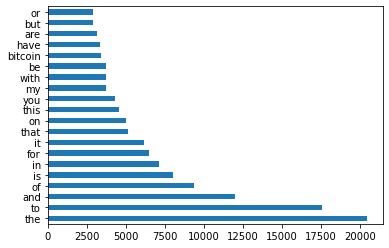

In [515]:
X = posts['text']
y = posts['subreddit']

# Split the data into the training and testing sets for a prelim CountVectorizer
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

cvec = CountVectorizer()
cvec.fit(X_train)
X_train = cvec.transform(X_train)
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names())
X_train_df.sum().sort_values(ascending=False).head(20).plot(kind='barh');

In [517]:
# add stop words to english stop words list

my_additional_stop_words = ['ethereum', 'bitcoin', 'eth', 'btc', 'reach', 
                            'large', 'paid', 'history', 'happen', 'understanding', 
                            'soon', 'fully', 'reddit', 'anybody', 'quite', 'coming',
                            'gone','period', 'cause', 'password', 'step', 'hour', 'note',
                            'explain', 'site', 'claim', 'whats', 'bad', 'wondering', 
                            '30', 'left', 'away', 'asking', 'figure', 'reading', 'regular', 
                            'leave', 'sign', 'stuff', 'return', 'line', 'legit', 
                           'exactly', 'completely', 'care','directly','given', 'entire',
                            'sort', 'form', 'wouldnt', 'bitcoins', 'ampx200b', '20k', 
                           'price', 'december']
my_stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

# source: https://stackoverflow.com/questions/24386489/adding-words-to-scikit-learns-countvectorizers-stop-list/24386751

### RandomForest GridSearching and Tuning Hyperparameters
- In this section, I construct a RandomForestClassifier model, run a gridsearch, and tune my hyperparameters

In [297]:
# run this cell for gridsearch on bigrams
X = posts[['text', 'sentiment']]
y = posts['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

pipe = Pipeline([
    ('features', FeatureUnion([
        ('numeric_features', Pipeline([
           ('selector', get_numeric_data), 
            ('ss', StandardScaler())
        ])),
        ('text_features', Pipeline([
        ('selector', get_text_data), 
        ('cvec', CountVectorizer(tokenizer=LemmaTokenizer(), stop_words=my_stop_words))
        ])),  
    ])),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'features__text_features__cvec__max_features': [7_185],
    'features__text_features__cvec__min_df': [1],
    'features__text_features__cvec__max_df': [.03],
    'features__text_features__cvec__ngram_range': [(2,2)],
    'rf__n_estimators' : [100], 
    'rf__max_depth' : [500],
    'rf__min_samples_split' : [50], 
    'rf__min_samples_leaf' : [50], 
}

bi_gram_gs = GridSearchCV(pipe, # what object are we optimizing?
                      param_grid=pipe_params, # what parameters values are we searching?
                      cv=10, 
                      verbose=2,
                      ) # 5-fold cross-validation.

t0 = time.time()

bi_gram_gs.fit(X_train, y_train)
print(f'Best Score: {bi_gram_gs.best_score_}') 
print(f'Train Set Score: {bi_gram_gs.score(X_train, y_train)}')
print(f'Test Set Score: {bi_gram_gs.score(X_test, y_test)}')
print(f'Best Parameters: {bi_gram_gs.best_params_}')

print(f' This cell took {time.time() - t0} seconds to run')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100, total=   4.2s
[CV] features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s
C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100, total=   4.2s
[CV] features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100, total=   4.2s
[CV] features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100, total=   4.2s
[CV] features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100, total=   4.3s
[CV] features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100, total=   4.2s
[CV] features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100, total=   4.2s
[CV] features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100, total=   4.3s
[CV] features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100, total=   4.3s
[CV] features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100 


C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


[CV]  features__text_features__cvec__max_df=0.03, features__text_features__cvec__max_features=7185, features__text_features__cvec__min_df=1, features__text_features__cvec__ngram_range=(2, 2), rf__max_depth=500, rf__min_samples_leaf=50, rf__min_samples_split=50, rf__n_estimators=100, total=   4.3s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   42.5s finished
C:\Users\tsuts\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Best Score: 0.5318621675844112
Train Set Score: 0.5318620286465946
Test Set Score: 0.5318896469890241
Best Parameters: {'features__text_features__cvec__max_df': 0.03, 'features__text_features__cvec__max_features': 7185, 'features__text_features__cvec__min_df': 1, 'features__text_features__cvec__ngram_range': (2, 2), 'rf__max_depth': 500, 'rf__min_samples_leaf': 50, 'rf__min_samples_split': 50, 'rf__n_estimators': 100}
 This cell took 52.49664044380188 seconds to run


In [ ]:
# run this cell for gridsearch on trigrams
X = posts[['text', 'sentiment']]
y = posts['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

pipe = Pipeline([
    ('features', FeatureUnion([
        ('numeric_features', Pipeline([
           ('selector', get_numeric_data), 
            ('ss', StandardScaler())
        ])),
        ('text_features', Pipeline([
        ('selector', get_text_data), 
        ('cvec', CountVectorizer(tokenizer=LemmaTokenizer(), stop_words=my_stop_words))
        ])),  
    ])),
    ('rf', RandomForestClassifier())
])

pipe_params = {
    'features__text_features__cvec__max_features': [7_185],
    'features__text_features__cvec__min_df': [1],
    'features__text_features__cvec__max_df': [.03],
    'features__text_features__cvec__ngram_range': [(3,3)],
    'rf__n_estimators' : [100, 200, 300, 600, 1000], 
    'rf__max_depth' : [80, 90, 100, 110],
    'rf__min_samples_split' : [10, 25, 50], 
    'rf__min_samples_leaf' : [3,4,5],
    'rf__max_features' : [2,3]
}

tri_grams_gs = GridSearchCV(pipe, # what object are we optimizing?
                      param_grid=pipe_params, # what parameters values are we searching?
                      cv=10, 
                      verbose=2,
                      ) # 5-fold cross-validation.

t0 = time.time()

tri_grams_gs.fit(X_train, y_train)
print(f'Best Score: {tri_grams_gs.best_score_}') 
print(f'Train Set Score: {tri_grams_gs.score(X_train, y_train)}')
print(f'Test Set Score: {tri_grams_gs.score(X_test, y_test)}')
print(f'Best Parameters: {tri_grams_gs.best_params_}')

print(f' This cell took {time.time() - t0} seconds to run')

### GridSearchHyperparameters
- At some point I want to go back and run a RandomSearchCV on my RandomForestClassifier to get the best possible hyperparameters for my model. 
 
- Best Parameters: 
     - cvec__max_df: 0.15 
     - cvec__max_features: 7180, 
     - cvec__min_df: 2 
     - cvec__ngram_range: (1, 1)
     - 'rf__max_depth': 500,
     - rf__min_samples_leaf': 20
     - rf__min_samples_split: 20
     - rf__n_estimators: 5


### Results
- Results from best model 


In [518]:
# get predictions
preds = gs.predict(X_test)


KeyError: "None of [Index(['sentiment'], dtype='object')] are in the [index]"

In [506]:
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
plot_confusion_matrix(gs, X, y, cmap='Blues', values_format='d');
 

KeyError: "None of [Index(['sentiment'], dtype='object')] are in the [index]"

In [460]:
tn

1375

In [419]:
# Accuracy 
acc = (tp+tn)/(tp+fp+tn+fn)
print('Accuracy:', acc)


# Specificity
spec = tn / (tn + fp)
print('Specificity:', spec)

# Sensitivity
sens = tp / (tp+fn)
print('Sensitivity:', sens)

# Precision 
prec = tp / (tp+fp)
print('Precision:', prec)


Accuracy: 0.8208246811035301
Specificity: 0.8713561470215463
Sensitivity: 0.7763524818739542
Precision: 0.8727272727272727


### Confusion Matrix Interpretation 

- The accuracy score tells us the percentage of observations my model correctly predicted. In other words, my model correctly predicted that a Bitcoin subreddit post was in fact in the r/Bitcoin subreddit 82.1% of the time. 
- The specificity tells us the percentage of Ethereum observations that I correctly predicted. In other words, my model correctly predicted that an Ethereum subreddit post was the r/Ethereum subreddit 87.1% of the time. 
- The sensitivity tells us the percentage of Bitcoin observations that I correctly predicted. In other words, my model correctly predicted r/Bitcoin posts 77.6% of the time. 
- The precision tells us the percentage of posts that I predicted to be Bitcoin subreddits were actually Bitcoin subreddits. In other words, 87.3% of the time, I correctly predicted Bitcoin subbredit posts. 


- Given the nature of my problem statement, it is nice to see that my model is decent given these scores. However, I'm not necessarily trying to optimize for a specific score. For my purposes, as long as I am correctly classifying whether a post is in r/Bitcoin or r/Ethereum, I am happy. With this in mind, the accuracy score of 82.1% isn't the best but it suffices. 
- Let's take a look at the F1 score, which is the harmonic mean of precision and recall (recall is the opposite of precision)

In [519]:
prec

0.8727272727272727

In [520]:
recall = recall_score(y_test, preds)
recall

0.7763524818739542

In [521]:
f_one = f1_score(y_test, preds)
print('F-Score: ', f_one)

F-Score:  0.8217237308146399


### ROC Curve

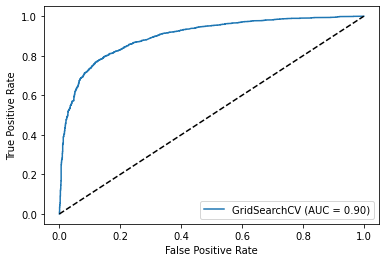

In [423]:
plot_roc_curve(gs, X_test, y_test);
plt.plot([0,1], [0,1], 'k--');

- The ROC curve shows us the performance of our model at all points from (0,1). It's comparing our true positive rate and our false positive along a curve. 
- It helps us visualize our tradeoff between sensitivity. 


In [424]:
predicted_probs = gs.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, predicted_probs[:,1])
print('ROC AUC Score: ', roc_auc)

ROC AUC Score:  0.8988899939703551


- .93 ROC AUC score means our positive and negative populations are distinct. My model does a good job of classifying r/Bitcoin posts and r/Ethereum posts! 

## Coefficients 

In [487]:
coefficients = gs.best_estimator_.named_steps['rf'].feature_importances_
features = gs.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['cvec'].get_feature_names()

#bi_gram_coefficients = bi_gram_gs.best_estimator_.named_steps['rf'].feature_importances_
#bi_gram_features = bi_gram_gs.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['cvec'].get_feature_names()

In [488]:
print(f'There are {len(coefficients)} coefficients.')
print(f'There are {len(features)} features.')

There are 7186 coefficients.
There are 7185 features.


In [489]:
features = ['sentiment_score'] +\
gs.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['cvec'].get_feature_names()

#bi_gram_features = ['sentiment_score'] +\
#bi_gram_gs.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['cvec'].get_feature_names()
# coefficients = gs.best_estimator_.named_steps['rf'].feature_importances_

In [490]:
coef_df = pd.DataFrame({'features': features, 
              'coef' : coefficients})
#bi_gram_coef_df = pd.DataFrame({'features': bi_gram_features, 
           #   'coef' : bi_gram_coefficients})
coef_df
 

,features,coef
0,sentiment_score,0.096826
1,000,0.000000
2,0000001,0.000000
3,000001,0.000000
4,000002,0.000000
...,...,...
7181,zrx,0.000000
7182,zuckerberg,0.000000
7183,zumo,0.000000
7184,zurich,0.000000


In [491]:
coef_df = coef_df.set_index('features')
coef_df = coef_df.sort_values('coef', ascending = False)
coef_df.head(10)

,coef
features,
sentiment_score,0.096826
dca,0.025671
sat,0.023981
etherscan,0.021451
21,0.020645
testnet,0.017496
developing,0.017424
geth,0.016641
implementation,0.016069


In [492]:
#bi_gram_coef_df = bi_gram_coef_df.set_index('features')
#bi_gram_coef_df = bi_gram_coef_df.sort_values('coef', ascending = False)
#bi_gram_coef_df.head(10)

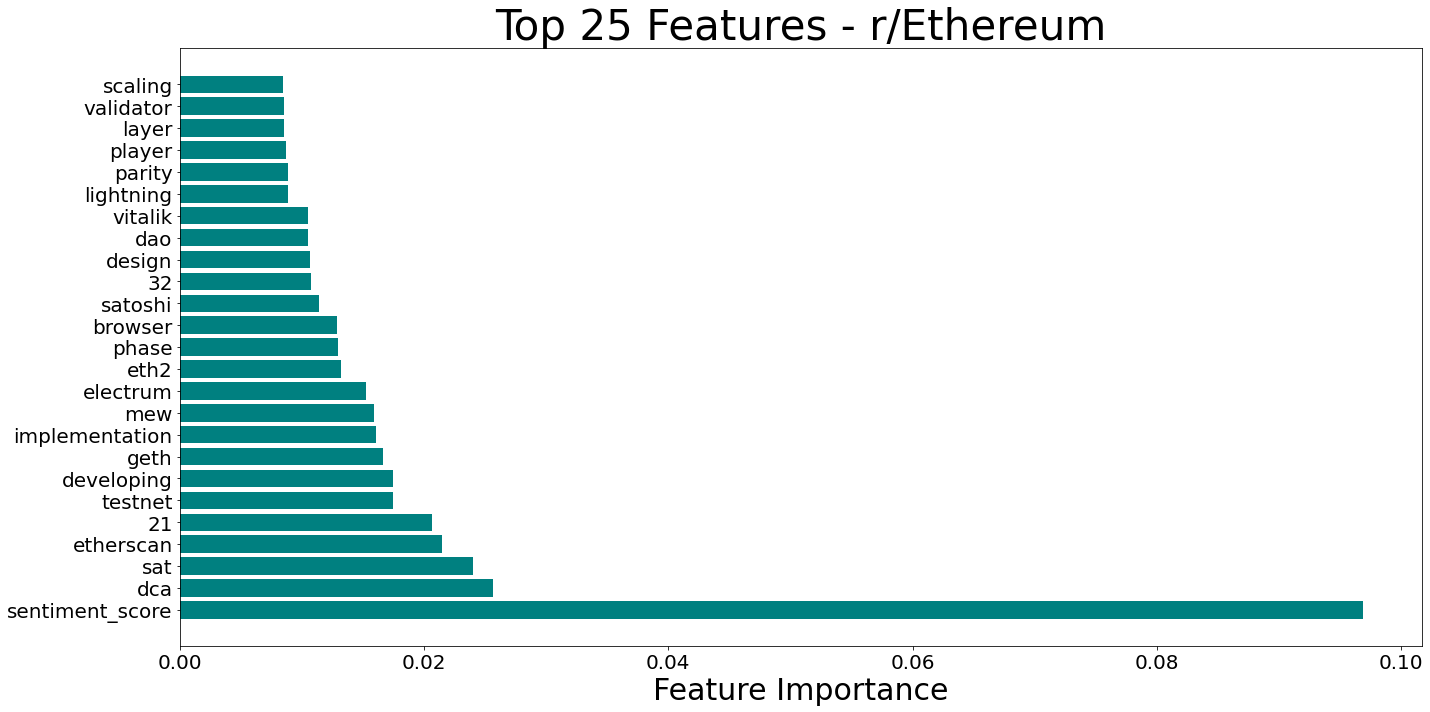

In [493]:
weights = coef_df['coef'].head(25)
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = 'teal')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Feature Importance', fontsize=30)
plt.title(f'Top 25 Features - r/Ethereum', fontsize=42)
plt.tight_layout()

In [494]:
coef_df = coef_df[coef_df['coef'] > 0]


In [495]:
coef_df.shape

(462, 1)

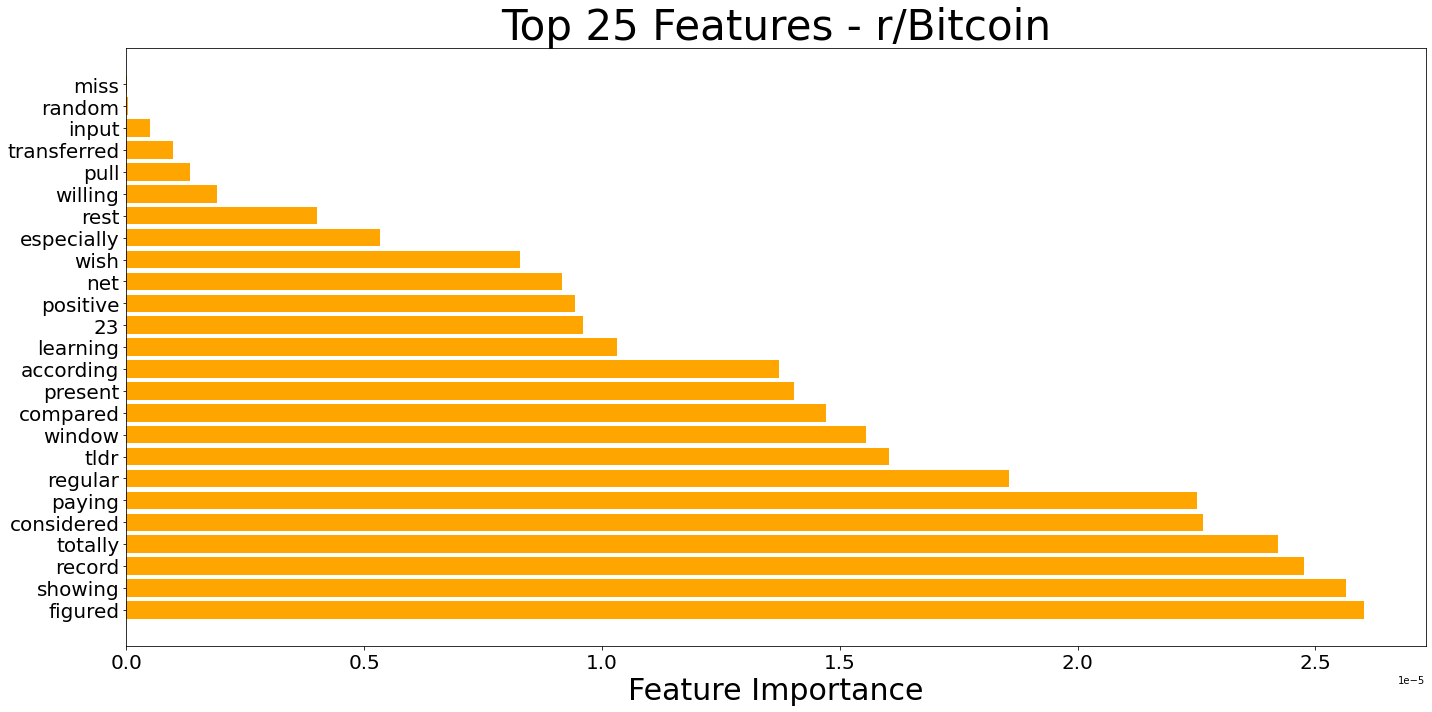

In [498]:
weights = coef_df['coef'].tail(25)
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = 'orange')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Feature Importance', fontsize=30)
plt.title(f'Top 25 Features - r/Bitcoin', fontsize=42)
plt.tight_layout()